In [1]:
# change directory
import os
rootdir = os.path.dirname(os.getcwd())
os.chdir(rootdir)

# import third libs for data
import datetime as dt
import numpy as np
import pandas as pd
from scipy import stats

# make imports
from utils import rendering as vw
from benchmarks import schema as sch
from config import DATA_DIR

In [2]:
benchmarkid = 'Dialysis2021'
dbmsid = 'MySql'

In [3]:
benchmarkname = 'HGD_dialysis_2018_2021'
benchmarkdir = os.path.join(DATA_DIR, 'raw', benchmarkname)
outputdir = os.path.join(DATA_DIR, 'results', benchmarkname)
if not os.path.isdir(outputdir):
    os.makedirs(outputdir)

## identification des periodes

In [4]:
patients_path = os.path.join(benchmarkdir, 'echantillons_patients.csv')
patients_sample = pd.read_csv(patients_path)
patients_sample.head()

,Date,number,day,release_date,due_date,duration,period,instance
0,2020-10-05,66,1,5,20,5,2020-10-11,w2020-10-11-m21
1,2020-10-06,72,2,5,20,5,2020-10-11,w2020-10-11-m21
2,2020-10-07,60,3,5,20,5,2020-10-11,w2020-10-11-m21
3,2020-10-08,63,4,5,20,5,2020-10-11,w2020-10-11-m21
4,2020-10-09,67,5,5,20,5,2020-10-11,w2020-10-11-m21


In [5]:
patients_sample.dtypes

Date            object
number           int64
day              int64
release_date     int64
due_date         int64
duration         int64
period          object
instance        object
dtype: object

In [6]:
periods = patients_sample['period']
periods = list(set(v for v in periods.to_dict().values()))
periods

['2021-01-31',
 '2021-01-03',
 '2020-10-11',
 '2021-04-04',
 '2020-10-18',
 '2020-11-29',
 '2020-11-15',
 '2021-01-17',
 '2021-03-21',
 '2020-12-06',
 '2021-04-25',
 '2020-11-01',
 '2021-05-02',
 '2021-05-09',
 '2020-11-22',
 '2021-01-24',
 '2021-03-14',
 '2020-12-13',
 '2020-12-20',
 '2020-10-25']

## Verification de la satisfaction

In [7]:
sql = f"""select p.name as problem_name, s.name as var_name, 
          s.value as value, e.model_name
          from statistics s, problems p, experiments e
          where s.exp_id = e.uid and e.problem_id = p.uid
          and e.model_name like 'RCEMP-DIAL'
          and s.name = 's'
          and p.name like '%m21'
          order by p.name, s.name, s.value;"""

In [8]:
statsview = vw.StatsView(benchmarkid, dbmsid)
data1 = statsview.load_results(sql)
data1.head()

,problem_name,var_name,value,model_name
0,w2020-10-11-m21,s,1.0,RCEMP-DIAL
1,w2020-10-18-m21,s,1.0,RCEMP-DIAL
2,w2020-10-25-m21,s,1.0,RCEMP-DIAL
3,w2020-11-01-m21,s,1.0,RCEMP-DIAL
4,w2020-11-15-m21,s,1.0,RCEMP-DIAL


In [9]:
data1[data1['value'] == 1].head()

,problem_name,var_name,value,model_name
0,w2020-10-11-m21,s,1.0,RCEMP-DIAL
1,w2020-10-18-m21,s,1.0,RCEMP-DIAL
2,w2020-10-25-m21,s,1.0,RCEMP-DIAL
3,w2020-11-01-m21,s,1.0,RCEMP-DIAL
4,w2020-11-15-m21,s,1.0,RCEMP-DIAL


## Calcul des retards reels

In [10]:
datapath = os.path.join(benchmarkdir, 'donnees_seances.csv')
seances = pd.read_csv(datapath, sep=';', index_col='Date', parse_dates=True, dayfirst=True)
seances.head()

,ID,Tour,Patients,Debut,Duree,jour
Date,,,,,,
2018-03-26,1,Tour1,21,5,5,0
2018-03-26,2,Tour2,21,10,5,0
2018-03-26,3,Tour3,21,15,5,0
2018-03-26,4,Tour4,8,20,5,0
2018-03-27,5,Tour1,21,5,5,1


In [11]:
retards = seances[seances.Tour == 'Tour4']
retards.head()

,ID,Tour,Patients,Debut,Duree,jour
Date,,,,,,
2018-03-26,4,Tour4,8,20,5,0
2018-03-27,8,Tour4,9,20,5,1
2018-03-28,12,Tour4,5,20,5,2
2018-03-29,16,Tour4,4,20,5,3
2018-03-30,20,Tour4,9,20,5,4


In [12]:
nR = retards['Patients']
R = retards['Patients'] * retards['Duree']
R.name, nR.name = 'R', 'nR'
R, nR = R.astype(int), nR.astype(int)
real_stats = pd.concat([R, nR], axis=1)
real_stats.head()

,R,nR
Date,,
2018-03-26,40,8
2018-03-27,45,9
2018-03-28,25,5
2018-03-29,20,4
2018-03-30,45,9


In [13]:
real_stats_hebdo = real_stats.resample('W').sum()
real_stats_hebdo.reset_index(inplace=True)
real_stats_hebdo = real_stats_hebdo[real_stats_hebdo['Date'].isin(periods)]
real_stats_hebdo.head()

,Date,R,nR
132,2020-10-11,85,17
133,2020-10-18,70,14
134,2020-10-25,50,10
135,2020-11-01,60,12
137,2020-11-15,90,18


In [14]:
real_stats_hebdo['problem'] = real_stats_hebdo['Date'].dt.strftime('w%Y-%m-%d-m21')
real_stats_hebdo.drop(['Date'], axis=1, inplace=True)
real_stats_hebdo.set_index('problem', inplace=True)
real_stats_hebdo.head()

,R,nR
problem,,
w2020-10-11-m21,85,17
w2020-10-18-m21,70,14
w2020-10-25-m21,50,10
w2020-11-01-m21,60,12
w2020-11-15-m21,90,18


In [15]:
real_stats_hebdo.shape

(20, 2)

## Collecte des retards simulees

In [16]:
filter_ = '%m21'
sql = f"""select p.name as problem_name, s.name as var_name, s.value 
                from statistics s, problems p, experiments e
                where s.exp_id = e.uid and e.problem_id = p.uid
                and e.model_name in ('RCEMP-DIAL')
                and s.name in ('R', 'nR')
                and p.name like '{filter_}'
                order by p.name, s.name, s.value;"""

In [17]:
statsview = vw.StatsView(benchmarkid, dbmsid)
data = statsview.load_results(sql)
data.head()

,problem_name,var_name,value
0,w2020-10-11-m21,nR,28.0
1,w2020-10-11-m21,R,180.0
2,w2020-10-18-m21,nR,24.0
3,w2020-10-18-m21,R,116.0
4,w2020-10-25-m21,nR,19.0


In [18]:
sim_vars = []
indexed_data = data.set_index('problem_name')
for var_name, var_data in indexed_data.groupby('var_name'):
    var = var_data['value']
    var.name = var_name
    sim_vars.append(var)
sim_data_hebdo = pd.concat(sim_vars, axis=1)
sim_data_hebdo.head()

,R,nR
problem_name,,
w2020-10-11-m21,180.0,28.0
w2020-10-18-m21,116.0,24.0
w2020-10-25-m21,100.0,19.0
w2020-11-01-m21,134.0,23.0
w2020-11-15-m21,90.0,18.0


## Comparaison des retards

In [19]:
compared_data = real_stats_hebdo.merge(sim_data_hebdo, left_index=True, right_index=True, suffixes=('_real', '_sim'))
compared_data['delta_R'] = ((compared_data['R_sim']/compared_data['R_real']) - 1) * 100
compared_data['delta_nR'] = ((compared_data['nR_sim']/compared_data['nR_real']) - 1) * 100
compared_data.head(25)

,R_real,nR_real,R_sim,nR_sim,delta_R,delta_nR
problem,,,,,,
w2020-10-11-m21,85,17,180.0,28.0,111.764706,64.705882
w2020-10-18-m21,70,14,116.0,24.0,65.714286,71.428571
w2020-10-25-m21,50,10,100.0,19.0,100.000000,90.000000
w2020-11-01-m21,60,12,134.0,23.0,123.333333,91.666667
w2020-11-15-m21,90,18,90.0,18.0,0.000000,0.000000
w2020-11-22-m21,80,16,80.0,16.0,0.000000,0.000000
w2020-11-29-m21,80,16,80.0,16.0,0.000000,0.000000
w2020-12-06-m21,170,34,170.0,34.0,0.000000,0.000000
w2020-12-13-m21,170,34,251.0,47.0,47.647059,38.235294


In [20]:
compared_data.sum()/compared_data.shape[0]

R_real      149.250000
nR_real      29.850000
R_sim       301.800000
nR_sim       48.700000
delta_R     104.442278
delta_nR     65.942081
dtype: float64

In [21]:
compared_data.index.name = 'instance'
compared_data.to_csv(os.path.join(outputdir, 'comparaison_retards.csv'))

## Calcul des disponibilites reels

In [22]:
def f(t):
    law = {'name':'norm', 'params':{'loc':336, 'scale':120}}
    device = sch.Device(name='1', use_duration=t, law=law)
    phm = sch.PHMModule()
    return phm.rul(device, next=False)

[f(i*100) for i in range(5)]

[0.0025551303304279793,
 0.0246108260876501,
 0.128537149342415,
 0.38208857781104744,
 0.7030985713961488]

In [23]:
import json

FILTER_LAMBDA = 2 * 7 * 24   # 2 weeks
GENERAL_LAMBDA = 365 * 24    # 1 year
FILTER_SIGMA = 120
GENERAL_SIGMA = 240
RISK_THRESHOLD = 0.1 #0.1 0.5 0.9
REPAIR_TIME = 1

In [24]:
GENERAL_LAMBDA

8760

In [25]:
GENERAL_LAMBDA = 5/4.5
GENERAL_LAMBDA

1.1111111111111112

In [26]:
def unavalaibility(row):
    MA = sch.Machine
    Dev = sch.Device
    CM = sch.ProductionCompetency
    FN = sch.Function

    ma = MA(uid=MA.next_uid(), name=row.code)
    cm = CM(uid=CM.next_uid(), activity='soin', capability=1, ressource=ma)
    f11 = FN(uid=FN.next_uid(), name='f1')
    f12 = FN(uid=FN.next_uid(), name='f2')
    f1 = FN(uid=FN.next_uid(), name='F1', competency=cm, machine=ma)
    f1.children.extend([f11, f12])

    param_f = {'loc':FILTER_LAMBDA, 'scale':FILTER_SIGMA}
    param_g = {'loc':GENERAL_LAMBDA, 'scale':GENERAL_SIGMA}
    
    law_f = lambda:json.dumps({'name':'norm', 'params':param_f})
    law_g = lambda:json.dumps({'name':'norm', 'params':param_g})
    # law_g = lambda:json.dumps({'name':'norm', 'params':{'scale':GENERAL_LAMBDA}})
            
    phm = sch.PHMModule(uid=sch.PHMModule.next_uid())
    kwargs = dict(phm_module=phm, machine=ma, repair_time=REPAIR_TIME,
                  risk_threshold=RISK_THRESHOLD,  use_duration=row.final_duration)
    dev1 = Dev(uid=Dev.next_uid(), name='Dv1', repair_skill='R1', json_law=law_g(), **kwargs)
    dev2 = Dev(uid=Dev.next_uid(), name='Dv2', repair_skill='R2', json_law=law_g(), **kwargs)
    dev3 = Dev(uid=Dev.next_uid(), name='Dv3', repair_skill='R3', json_law=law_g(), **kwargs)
    dev4 = Dev(uid=Dev.next_uid(), name='Dv4', repair_skill='R4', json_law=law_g(), **kwargs)
    dev5 = Dev(uid=Dev.next_uid(), name='Dv5', repair_skill='R5', json_law=law_g(), **kwargs)
    dev6 = Dev(uid=Dev.next_uid(), name='Dv6', repair_skill='R6', json_law=law_g(), **kwargs)
    dev7 = Dev(uid=Dev.next_uid(), name='Dv7', repair_skill='R7', json_law=law_g(), **kwargs)
    dev8 = Dev(uid=Dev.next_uid(), name='Dv8', repair_skill='R8', json_law=law_g(), **kwargs)
    dev9 = Dev(uid=Dev.next_uid(), name='Dv9', repair_skill='R9', json_law=law_g(), **kwargs)
    dev10 = Dev(uid=Dev.next_uid(), name='Dv10', repair_skill='R10', json_law=law_f(), **kwargs)
    dev11 = Dev(uid=Dev.next_uid(), name='Dv11', repair_skill='R11', json_law=law_g(), **kwargs)
    dev12 = Dev(uid=Dev.next_uid(), name='Dv12', repair_skill='R12', json_law=law_g(), **kwargs)
    dev13 = Dev(uid=Dev.next_uid(), name='Dv13', repair_skill='R13', json_law=law_g(), **kwargs)
    dev14 = Dev(uid=Dev.next_uid(), name='Dv14', repair_skill='R14', json_law=law_g(), **kwargs)
    dev15 = Dev(uid=Dev.next_uid(), name='Dv15', repair_skill='R15', json_law=law_g(), **kwargs)
    f11.devices.extend([dev1, dev2, dev3, dev4, dev5, dev6])
    f12.devices.extend([dev6, dev7, dev8, dev9, dev10, dev11, dev12, dev13, dev14, dev15])
    return f1.rul(next=False)

In [27]:
1/365*24

0.06575342465753425

In [28]:
MTBF = 365 * 24 * 2
lambda_ = 1/MTBF
lambda_

5.7077625570776254e-05

In [29]:
datapath = os.path.join(benchmarkdir, 'echantillons_machines.csv')
machines = pd.read_csv(datapath, sep=',', index_col=0)
machines.head()

,code,period,use_duration,final_duration,nb_jour,total_pannes,instance
46,7SXAWU81,2020-10-11,308,612,7.0,0,w2020-10-11-m21
86,7SXAWS81,2020-10-11,6628,6932,7.0,0,w2020-10-11-m21
106,7SXAWU96,2020-10-11,3384,3688,7.0,0,w2020-10-11-m21
126,7SXAWU87,2020-10-11,1864,2168,7.0,0,w2020-10-11-m21
146,7SXAWT98,2020-10-11,41216,41520,7.0,0,w2020-10-11-m21


In [30]:
unavail_machines = machines.copy()
unavail_machines['Abar'] = machines.apply(unavalaibility, axis=1)
unavail_machines[unavail_machines['Abar'] < 0.5].head()

,code,period,use_duration,final_duration,nb_jour,total_pannes,instance,Abar
69,7SXAWU90,2020-10-25,48,344,7.0,0,w2020-10-25-m21,0.159478
289,7SXAWU93,2020-10-25,0,292,7.0,0,w2020-10-25-m21,0.059331
147,7SXAWT98,2020-11-22,0,312,7.0,0,w2020-11-22-m21,0.090163
168,7SXAWU86,2020-12-06,212,212,0.0,0,w2020-12-06-m21,0.006415
163,7SXAWU86,2020-12-13,212,384,3.0,0,w2020-12-13-m21,0.279144


In [31]:
no_cols = ['use_duration', 'final_duration', 'code', 'period', 'nb_jour', 'total_pannes']
unavail_reel = unavail_machines.drop(no_cols, axis=1).groupby('instance').aggregate(np.product)
unavail_reel['Abar'] = 1 - unavail_reel['Abar']
unavail_reel.head()

,Abar
instance,
w2020-10-11-m21,0.516854
w2020-10-11-m4,0.193508
w2020-10-18-m21,0.422549
w2020-10-18-m4,0.004071
w2020-10-25-m21,0.990538


## Collecte des disponibilites simulees

In [32]:
sql = f"""select p.name as problem_name, s.name as var_name, s.value as value
                from statistics s, problems p, experiments e
                where s.exp_id = e.uid and e.problem_id = p.uid
                and e.model_name = 'RCEMP-DIAL'
                and s.name = 'Abar'
                and p.name like '%m21'
                order by p.name, s.name, s.value;"""

In [33]:
statsview = vw.StatsView(benchmarkid, dbmsid)
data = statsview.load_results(sql)
data.head()

,problem_name,var_name,value
0,w2020-10-11-m21,Abar,0.0
1,w2020-10-18-m21,Abar,0.0
2,w2020-10-25-m21,Abar,0.0
3,w2020-11-01-m21,Abar,0.0
4,w2020-11-15-m21,Abar,0.0


In [34]:
unavail_sim = data.copy()
unavail_sim['Abar'] = unavail_sim['value']
unavail_sim.drop(['var_name', 'value'], axis=1, inplace=True)
unavail_sim.set_index('problem_name', inplace=True)
unavail_sim

,Abar
problem_name,
w2020-10-11-m21,0.0
w2020-10-18-m21,0.0
w2020-10-25-m21,0.0
w2020-11-01-m21,0.0
w2020-11-15-m21,0.0
w2020-11-22-m21,0.0
w2020-11-29-m21,0.0
w2020-12-06-m21,0.0
w2020-12-13-m21,0.0


## Comparaison des disponibilites

In [35]:
unavail_reel.merge(unavail_sim, left_index=True, right_index=True, suffixes=('_real', '_sim'))

,Abar_real,Abar_sim
w2020-10-11-m21,5.168536e-01,0.0
w2020-10-18-m21,4.225489e-01,0.0
w2020-10-25-m21,9.905384e-01,0.0
w2020-11-01-m21,1.684351e-01,0.0
w2020-11-15-m21,7.378015e-06,0.0
w2020-11-22-m21,9.098372e-01,0.0
w2020-11-29-m21,8.869504e-02,0.0
w2020-12-06-m21,9.962600e-01,0.0
w2020-12-13-m21,9.999946e-01,0.0
w2020-12-20-m21,9.347773e-01,0.0


In [36]:
compared_unavail = unavail_reel.merge(unavail_sim, left_index=True, right_index=True, suffixes=('_real', '_sim'))
compared_unavail['delta_Abar'] = compared_unavail['Abar_sim']-compared_unavail['Abar_real']
compared_unavail

,Abar_real,Abar_sim,delta_Abar
w2020-10-11-m21,5.168536e-01,0.0,-5.168536e-01
w2020-10-18-m21,4.225489e-01,0.0,-4.225489e-01
w2020-10-25-m21,9.905384e-01,0.0,-9.905384e-01
w2020-11-01-m21,1.684351e-01,0.0,-1.684351e-01
w2020-11-15-m21,7.378015e-06,0.0,-7.378015e-06
w2020-11-22-m21,9.098372e-01,0.0,-9.098372e-01
w2020-11-29-m21,8.869504e-02,0.0,-8.869504e-02
w2020-12-06-m21,9.962600e-01,0.0,-9.962600e-01
w2020-12-13-m21,9.999946e-01,0.0,-9.999946e-01
w2020-12-20-m21,9.347773e-01,0.0,-9.347773e-01


In [37]:
compared_unavail.index.name = 'instance'
compared_unavail.to_csv(os.path.join(outputdir, 'comparaison_disponiblite.csv'))

## Comparison des methodes

In [38]:
sql = f"""select p.name as problem_name, s.name as var_name, 
          s.value as value, e.model_name
          from statistics s, problems p, experiments e
          where s.exp_id = e.uid and e.problem_id = p.uid
          and e.model_name like 'RCEMP-DIAL%'
          and s.name in ('Abar', 'nR', 's')
          and p.name like '%m4'
          order by p.name, s.name, s.value;"""

In [39]:
statsview = vw.StatsView(benchmarkid, dbmsid)
data1 = statsview.load_results(sql)
data1.head()

,problem_name,var_name,value,model_name
0,w2020-10-11-m4,Abar,0.0,RCEMP-DIAL-m-EDD
1,w2020-10-11-m4,Abar,0.0,RCEMP-DIAL-p-EDD
2,w2020-10-11-m4,Abar,0.0,RCEMP-DIAL
3,w2020-10-11-m4,Abar,0.0,RCEMP-DIAL-m-FIFO
4,w2020-10-11-m4,Abar,0.0,RCEMP-DIAL-p-FIFO


In [40]:
model_names = {'RCEMP-DIAL':'x-WFIFO', 
               'RCEMP-DIAL-p-EDD':'p-EDD',
               'RCEMP-DIAL-p-FIFO':'p-FIFO',
               'RCEMP-DIAL-m-EDD':'m-EDD',
               'RCEMP-DIAL-m-FIFO':'m-FIFO'}
data2 = data1.copy()
data2['model_name'] = data2['model_name'].replace(model_names)
data2.head()


,problem_name,var_name,value,model_name
0,w2020-10-11-m4,Abar,0.0,m-EDD
1,w2020-10-11-m4,Abar,0.0,p-EDD
2,w2020-10-11-m4,Abar,0.0,x-WFIFO
3,w2020-10-11-m4,Abar,0.0,m-FIFO
4,w2020-10-11-m4,Abar,0.0,p-FIFO


In [41]:
data3 = pd.pivot_table(data2, values='value', 
                       index='problem_name', 
                       columns=['var_name','model_name'])

In [42]:
data3.head()

var_name        Abar                                nR                      \
model_name     m-EDD m-FIFO p-EDD p-FIFO x-WFIFO m-EDD m-FIFO p-EDD p-FIFO   
problem_name                                                                 
w2020-10-11-m4   0.0    0.0   0.0    0.0     0.0   1.0    1.0  48.0   48.0   
w2020-10-18-m4   0.0    0.0   0.0    0.0     0.0   2.0    2.0  46.0   46.0   
w2020-10-25-m4   0.0    0.0   0.0    0.0     0.0   5.0    5.0  46.0   46.0   
w2020-11-01-m4   0.0    0.0   0.0    0.0     0.0   2.0    2.0  48.0   48.0   
w2020-11-15-m4   0.0    0.0   0.0    0.0     0.0   3.0    3.0  46.0   46.0   

var_name                   s                                     
model_name     x-WFIFO m-EDD m-FIFO     p-EDD    p-FIFO x-WFIFO  
problem_name                                                     
w2020-10-11-m4     1.0   1.0    1.0  0.915385  0.915385     1.0  
w2020-10-18-m4     0.0   1.0    1.0  0.930233  0.930233     1.0  
w2020-10-25-m4     4.0   1.0    1.0  0.930070  0.930070     1.0  
w2020-11-01-m4     0.0   1.0    1.0  0.923077  0.923077     1.0  
w2020-11-15-m4     1.0   1.0    1.0  0.923664  0.923664     1.0

In [43]:
rule_abar = data3['Abar']
rule_abar.head()

model_name,m-EDD,m-FIFO,p-EDD,p-FIFO,x-WFIFO
problem_name,,,,,
w2020-10-11-m4,0.0,0.0,0.0,0.0,0.0
w2020-10-18-m4,0.0,0.0,0.0,0.0,0.0
w2020-10-25-m4,0.0,0.0,0.0,0.0,0.0
w2020-11-01-m4,0.0,0.0,0.0,0.0,0.0
w2020-11-15-m4,0.0,0.0,0.0,0.0,0.0


In [44]:
rule_nr = data3['nR']
rule_nr.head()

model_name,m-EDD,m-FIFO,p-EDD,p-FIFO,x-WFIFO
problem_name,,,,,
w2020-10-11-m4,1.0,1.0,48.0,48.0,1.0
w2020-10-18-m4,2.0,2.0,46.0,46.0,0.0
w2020-10-25-m4,5.0,5.0,46.0,46.0,4.0
w2020-11-01-m4,2.0,2.0,48.0,48.0,0.0
w2020-11-15-m4,3.0,3.0,46.0,46.0,1.0


In [45]:
rule_nr.sum()/rule_nr.shape[0]

model_name
m-EDD       5.75
m-FIFO      5.75
p-EDD      47.70
p-FIFO     47.70
x-WFIFO     3.80
dtype: float64

In [46]:
rule_s = data3['s']
rule_s.head(25)

model_name,m-EDD,m-FIFO,p-EDD,p-FIFO,x-WFIFO
problem_name,,,,,
w2020-10-11-m4,1.0,1.0,0.915385,0.915385,1.0
w2020-10-18-m4,1.0,1.0,0.930233,0.930233,1.0
w2020-10-25-m4,1.0,1.0,0.930070,0.930070,1.0
w2020-11-01-m4,1.0,1.0,0.923077,0.923077,1.0
w2020-11-15-m4,1.0,1.0,0.923664,0.923664,1.0
w2020-11-22-m4,1.0,1.0,0.909091,0.909091,1.0
w2020-11-29-m4,1.0,1.0,0.923077,0.923077,1.0
w2020-12-06-m4,1.0,1.0,0.897059,0.897059,1.0
w2020-12-13-m4,1.0,1.0,0.903704,0.903704,1.0


In [47]:
rule_s.sum()/rule_s.shape[0]

model_name
m-EDD      1.00000
m-FIFO     1.00000
p-EDD      0.90429
p-FIFO     0.90429
x-WFIFO    1.00000
dtype: float64

In [48]:
rule_abar.to_csv(os.path.join(outputdir, 'comparaison_regles_abar.csv'))
rule_nr.to_csv(os.path.join(outputdir, 'comparaison_regles_nr.csv'))
rule_s.to_csv(os.path.join(outputdir, 'comparaison_regles_s.csv'))

## Tests statistiques

### Test de wilcoxon

In [49]:
x1 = compared_unavail['Abar_real']
x2 = compared_unavail['Abar_sim']
u_abar = stats.wilcoxon(x1, x2, alternative='two-sided', mode='approx')
u_abar

WilcoxonResult(statistic=0.0, pvalue=8.857457687863547e-05)

In [50]:
x1 = compared_data['nR_real']
x2 = compared_data['nR_sim']
u_nr = stats.wilcoxon(x1, x2, alternative='two-sided', mode='approx')
u_nr

WilcoxonResult(statistic=0.0, pvalue=0.0004329514754108668)

In [51]:
x1 = compared_data['R_real']
x2 = compared_data['R_sim']
u_r = stats.wilcoxon(x1, x2, alternative='two-sided', mode='approx')
u_r

WilcoxonResult(statistic=0.0, pvalue=0.0004358423668112835)

In [52]:
outputpath = os.path.join(outputdir, 'test_wilcoxon.csv')
data = [{'stat':u_abar.statistic, 'p-value':u_abar.pvalue, 'var':'Abar'},
        {'stat':u_nr.statistic, 'p-value':u_nr.pvalue, 'var':'nR'},
        {'stat':u_r.statistic, 'p-value':u_r.pvalue, 'var':'R'}]
pd.DataFrame(data).to_csv(outputpath, index=False)

### Test de Friedmann (producer rule)

In [53]:
x1 = rule_abar['x-WFIFO']
x2 = rule_abar['p-FIFO']
x3 = rule_abar['p-EDD']
q_prod_abar = stats.friedmanchisquare(x1, x2, x3)
q_prod_abar

C:\Users\MalcomDev\miniconda3\envs\pyenv_rcemp_02\Lib\site-packages\scipy\stats\_stats_py.py:9427: RuntimeWarning: invalid value encountered in scalar divide
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c


FriedmanchisquareResult(statistic=nan, pvalue=nan)

In [54]:
x1 = rule_nr['x-WFIFO']
x2 = rule_nr['p-FIFO']
x3 = rule_nr['p-EDD']
q_prod_nr = stats.friedmanchisquare(x1, x2, x3)
q_prod_nr

FriedmanchisquareResult(statistic=40.0, pvalue=2.0611536224385566e-09)

In [55]:
x1 = rule_s['x-WFIFO']
x2 = rule_s['p-FIFO']
x3 = rule_s['p-EDD']
q_prod_s = stats.friedmanchisquare(x1, x2, x3)
q_prod_s

FriedmanchisquareResult(statistic=40.0, pvalue=2.0611536224385566e-09)

In [56]:
outputpath = os.path.join(outputdir, 'test_friedmann_production.csv')
data = [{'stat':q_prod_abar.statistic, 'p-value':q_prod_abar.pvalue, 'var':'Abar'},
        {'stat':q_prod_nr.statistic, 'p-value':q_prod_nr.pvalue, 'var':'nR'},
        {'stat':q_prod_s.statistic, 'p-value':q_prod_s.pvalue, 'var':'s'}]
pd.DataFrame(data).to_csv(outputpath, index=False)

### Test de Friedmann (maintener rule)

In [57]:
x1 = rule_abar['x-WFIFO']
x2 = rule_abar['m-FIFO']
x3 = rule_abar['m-EDD']
q_maint_abar = stats.friedmanchisquare(x1, x2, x3)
q_maint_abar

C:\Users\MalcomDev\miniconda3\envs\pyenv_rcemp_02\Lib\site-packages\scipy\stats\_stats_py.py:9427: RuntimeWarning: invalid value encountered in scalar divide
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c


FriedmanchisquareResult(statistic=nan, pvalue=nan)

In [58]:
x1 = rule_nr['x-WFIFO']
x2 = rule_nr['m-FIFO']
x3 = rule_nr['m-EDD']
q_maint_nr = stats.friedmanchisquare(x1, x2, x3)
q_maint_nr

FriedmanchisquareResult(statistic=36.000000000000014, pvalue=1.5229979744712527e-08)

In [59]:
x1 = rule_s['x-WFIFO']
x2 = rule_s['m-FIFO']
x3 = rule_s['m-EDD']
q_maint_s = stats.friedmanchisquare(x1, x2, x3)
q_maint_s

FriedmanchisquareResult(statistic=nan, pvalue=nan)

In [60]:
outputpath = os.path.join(outputdir, 'test_friedmann_maintenance.csv')
data = [{'stat':q_maint_abar.statistic, 'p-value':q_maint_abar.pvalue, 'var':'Abar'},
        {'stat':q_maint_nr.statistic, 'p-value':q_maint_nr.pvalue, 'var':'nR'},
        {'stat':q_maint_s.statistic, 'p-value':q_maint_s.pvalue, 'var':'s'}]
pd.DataFrame(data).to_csv(outputpath, index=False)

## Choix des diagrammes de Gantt

### Listing des diagrammes

In [61]:
ganttview = vw.GanttView(benchmarkid, dbmsid)
ganttview

In [62]:
# f = lambda exp: f"{exp['problem_name']} {exp['model_name']}"
# ganttview.plot('w2018%21', '%CEMP%', time_window=(0, 168), title_format=f)

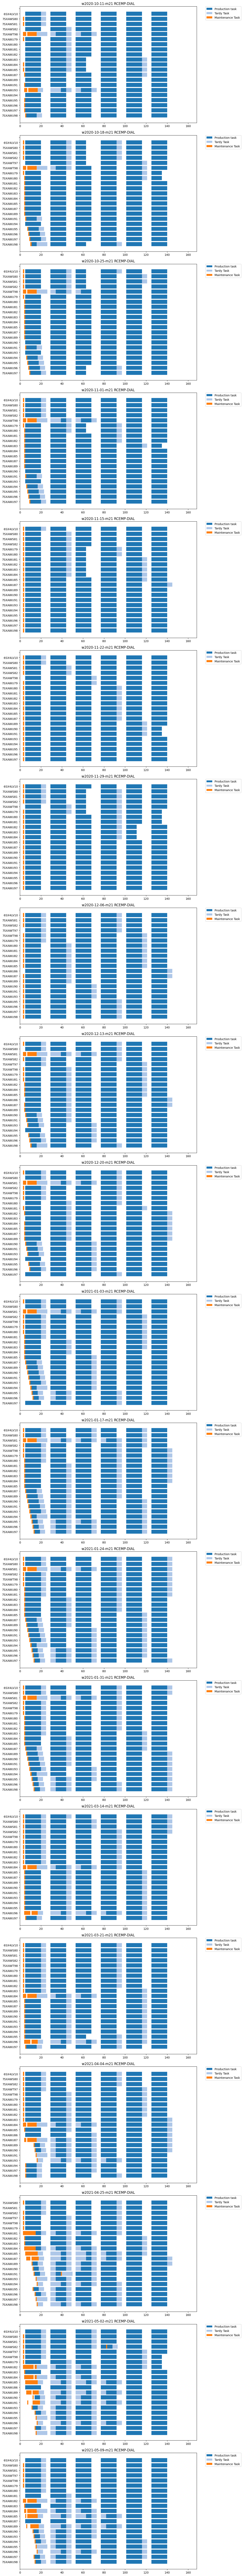

In [63]:
f = lambda exp: f"{exp['problem_name']} {exp['model_name']}"
ganttview.plot('%m21', 'RCEMP-DIAL', time_window=(0, 168), title_format=f)

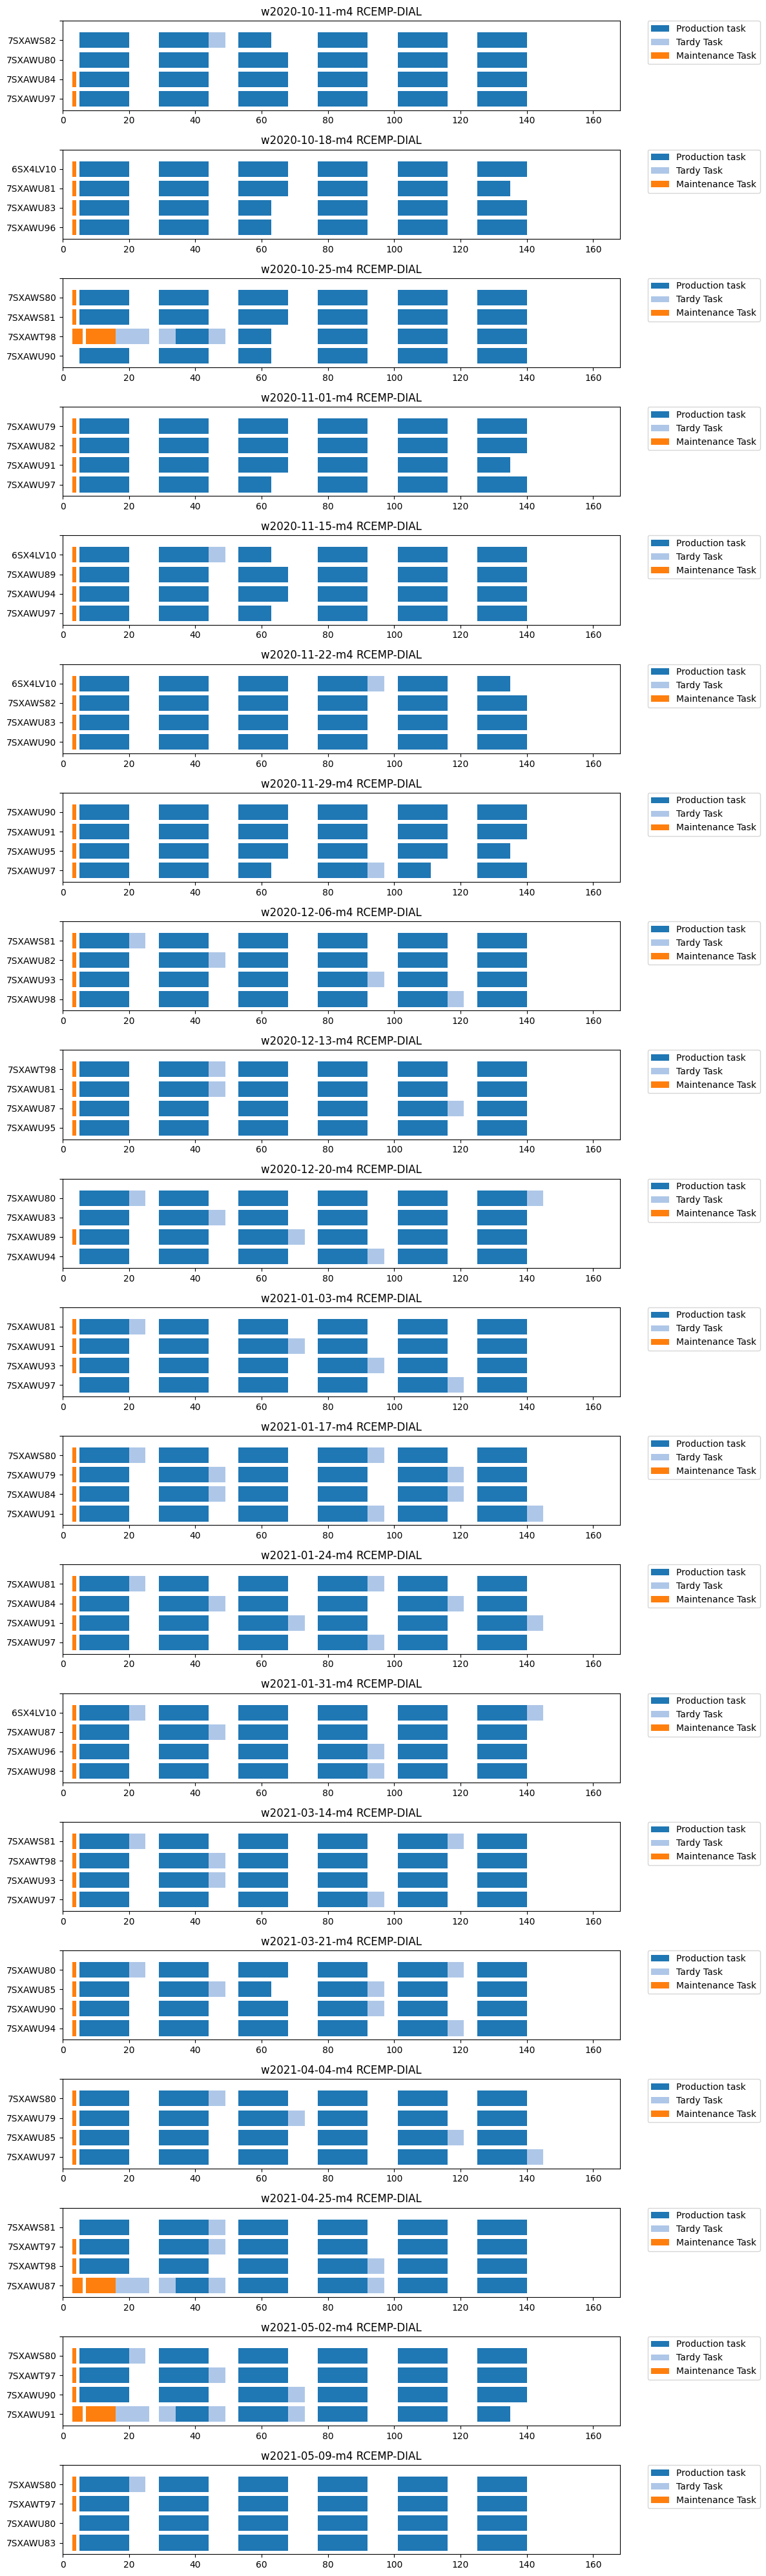

In [65]:
f = lambda exp: f"{exp['problem_name']} {exp['model_name']}"
ganttview.plot('%m4', 'RCEMP-DIAL', time_window=(0, 168), title_format=f)

### Choix de la periode

In [73]:
ganttchoice = 'w2021-05-09-m4'

### Diagramme avec regles (production)

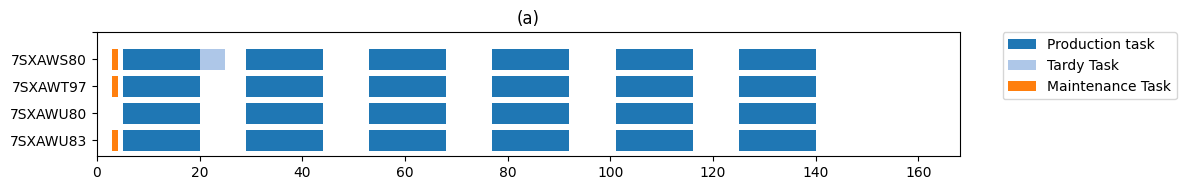

In [74]:
f = lambda exp: '(a)'
ganttview.plot(ganttchoice, 'RCEMP-DIAL', time_window=(0, 168), 
               title_format=f, saveas=os.path.join(outputdir, 'gantt_with_WFIFO(Prod).png'))

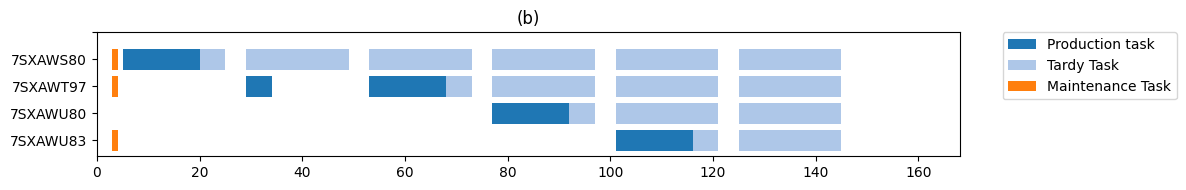

In [75]:
f = lambda exp: '(b)'
ganttview.plot(ganttchoice, 'RCEMP-DIAL-p-FIFO', time_window=(0, 168), 
               title_format=f, saveas=os.path.join(outputdir, 'gantt_with_FIFO(Prod).png'))

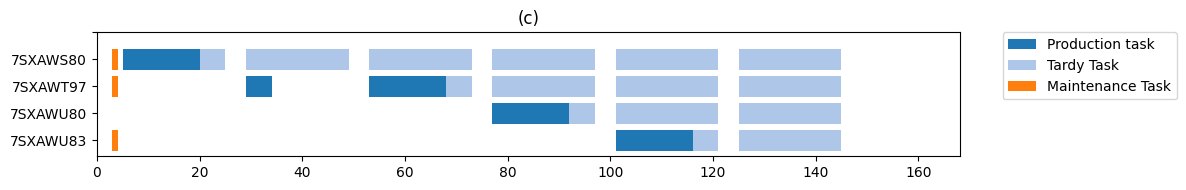

In [76]:
f = lambda exp: '(c)'
ganttview.plot(ganttchoice, 'RCEMP-DIAL-p-EDD', time_window=(0, 168), 
               title_format=f, saveas=os.path.join(outputdir, 'gantt_with_EDD(Prod).png'))

### Diagramme avec regles (maintenance)

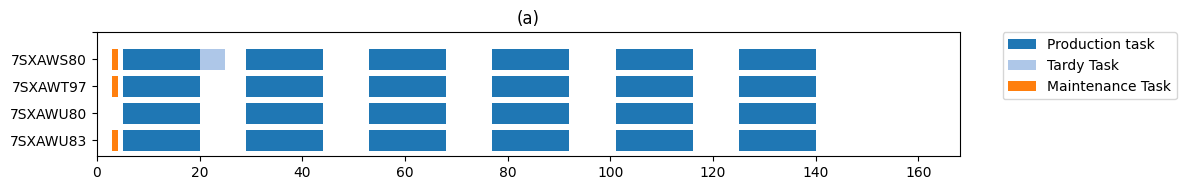

In [77]:
f = lambda exp: '(a)'
ganttview.plot(ganttchoice, 'RCEMP-DIAL', time_window=(0, 168), 
               title_format=f, saveas=os.path.join(outputdir, 'gantt_with_WFIFO(Maint).png'))

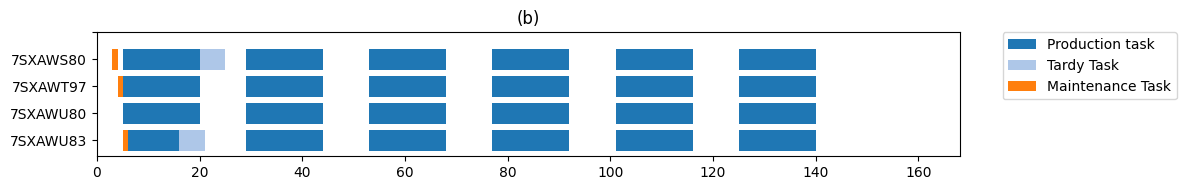

In [78]:
f = lambda exp: '(b)'
ganttview.plot(ganttchoice, 'RCEMP-DIAL-m-FIFO', time_window=(0, 168), 
               title_format=f, saveas=os.path.join(outputdir, 'gantt_with_FIFO(Maint).png'))

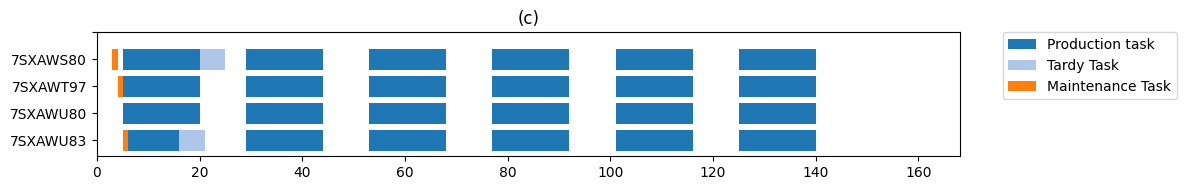

In [79]:
f = lambda exp: '(c)'
ganttview.plot(ganttchoice, 'RCEMP-DIAL-m-EDD', time_window=(0, 168), 
               title_format=f, saveas=os.path.join(outputdir, 'gantt_with_EDD(Maint).png'))

In [ ]:
# var_names = prod_var_names + maint_var_names + exec_var_names
# statsview.test(var_names, problem_filter='%', save_as='test_performances.csv')